# **DSA4262 Individual Assignment 2**
**Name:** Tung Yi Faye  
**Date:** 25 Feb 2026  
**GitHub Repository:** https://github.com/tungyifaye/DSA4262

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

sns.set_theme(style="whitegrid")

In [ ]:
def set_seed(seed):
    import random
    import numpy as np

    random.seed(seed)
    np.random.seed(seed)

set_seed(42)

## **1. Data Loading and Initial Inspection**
### **1.1 Dataset Overview**
This dataset contains Reddit posts labelled as:
- 1 = Stressed
- 0 = Not stressed

In [ ]:
train_df = pd.read_csv("../data/dreaddit-train.csv")
test_df = pd.read_csv("../data/dreaddit-test.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

train_df.head()

Train shape: (2838, 116)
Test shape: (715, 116)


subreddit post_id sentence_range  \
0              ptsd  8601tu       (15, 20)   
1        assistance  8lbrx9         (0, 5)   
2              ptsd  9ch1zh       (15, 20)   
3     relationships  7rorpp        [5, 10]   
4  survivorsofabuse  9p2gbc         [0, 5]   

                                                text     id  label  \
0  He said he had not felt that way before, sugge...  33181      1   
1  Hey there r/assistance, Not sure if this is th...   2606      0   
2  My mom then hit me with the newspaper and it s...  38816      1   
3  until i met my new boyfriend, he is amazing, h...    239      1   
4  October is Domestic Violence Awareness Month a...   1421      1   

   confidence  social_timestamp  social_karma  syntax_ari  ...  \
0         0.8        1521614353             5    1.806818  ...   
1         1.0        1527009817             4    9.429737  ...   
2         0.8        1535935605             2    7.769821  ...   
3         0.6        1516429555             0    2.667798  ...   
4         0.8        1539809005            24    7.554238  ...   

   lex_dal_min_pleasantness  lex_dal_min_activation  lex_dal_min_imagery  \
0                     1.000                  1.1250                  1.0   
1                     1.125                  1.0000                  1.0   
2                     1.000                  1.1429                  1.0   
3                     1.000                  1.1250                  1.0   
4                     1.000                  1.1250                  1.0   

   lex_dal_avg_activation  lex_dal_avg_imagery  lex_dal_avg_pleasantness  \
0                 1.77000              1.52211                   1.89556   
1                 1.69586              1.62045                   1.88919   
2                 1.83088              1.58108                   1.85828   
3                 1.75356              1.52114                   1.98848   
4                 1.77644              1.64872                   1.81456   

   social_upvote_ratio  social_num_comments  syntax_fk_grade  sentiment  
0                 0.86                    1         3.253573  -0.002742  
1                 0.65                    2         8.828316   0.292857  
2                 0.67                    0         7.841667   0.011894  
3                 0.50                    5         4.104027   0.141671  
4                 1.00                    1         7.910952  -0.204167  

[5 rows x 116 columns]

In [ ]:
# Check missing values
train_df.isnull().sum().sort_values(ascending=False).head(10)

subreddit           0
post_id             0
sentence_range      0
text                0
id                  0
label               0
confidence          0
social_timestamp    0
social_karma        0
syntax_ari          0
dtype: int64

### **1.2 Class Distribution**
The label distribution is:
- Stressed (1): 52.43%
- Non-stressed (0): 47.47%  

The dataset is **approximately balanced**, with only a slight majority of stressed posts. Because the imbalance is minimal (5%), no resampling was required.

In [ ]:
# Check label distribution
train_df['label'].value_counts(normalize=True)

label
1    0.524313
0    0.475687
Name: proportion, dtype: float64

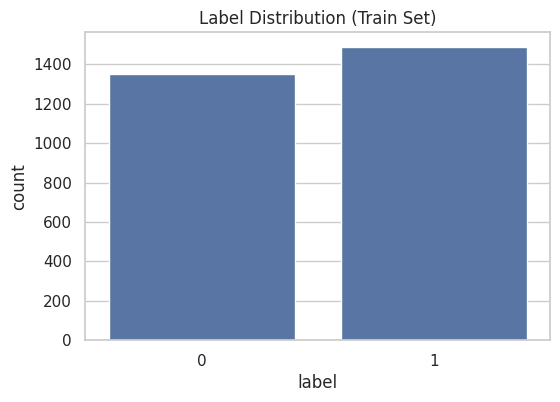

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=train_df, x="label")
plt.title("Label Distribution (Train Set)")
plt.show()

## **2. Exploratory Data Analysis (EDA)**
### **2.1 Subreddit-Level Stress Proportions**
The subreddits with the highest proportion of stressed posts were:
- *anxiety*
- *domestic violence*
- *almosthomeless*
- *ptsd*
- *stress*  

with proportions ranging approximately 0.55-0.65.  

This aligns strongly with psychological expectations:
- **Anxiety/PTSD** communities naturally contain distress-related narratives
- **Domestic violence and housing instability** are known chronic stressors
- This confirms that the label distribution is contextually meaningful rather than random noise  

This supports the **construct validity** of the dataset.

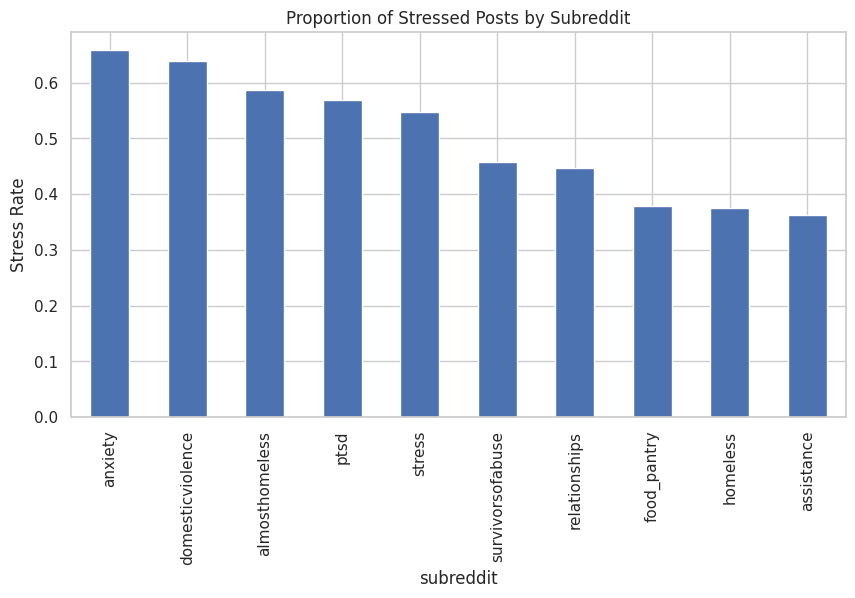

In [ ]:
subreddit_stress = (
    train_df
    .groupby("subreddit")["label"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10,5))
subreddit_stress.plot(kind="bar")
plt.title("Proportion of Stressed Posts by Subreddit")
plt.ylabel("Stress Rate")
plt.show()

#### **2.2 Text Length Analysis**
A boxplot comparing text length across stress labels showed similar mean and interquartile ranges for both labels.

This suggests:
- Text length alone is **not a strong predictor**
- The model must rely on **semantic and emotional content**, not superficial length cues  

This is important for methodological rigour -- it indicates the model is unlikely to be exploiting trivial features.

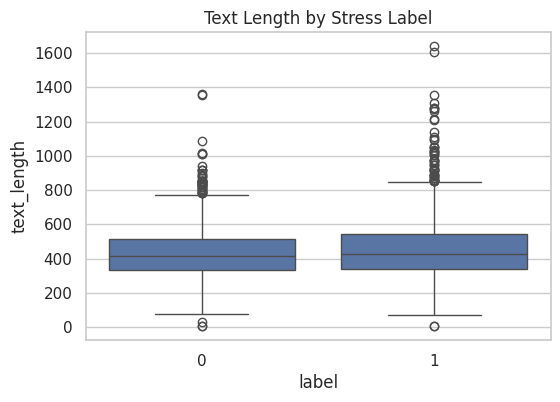

In [ ]:
train_df["text_length"] = train_df["text"].apply(len)

plt.figure(figsize=(6,4))
sns.boxplot(data=train_df, x="label", y="text_length")
plt.title("Text Length by Stress Label")
plt.show()

## **3. Model Development: BERT**
### **3.1 Rationale for Using BERT**
We adopted a pretrained Transformer-based model (BERT) for binary stress classification due to its ability to capture contextual and semantic nuances in informal text.

Unlike traditional bag-of-words or TF-IDF approaches, which treat words independently, BERT produces **context-aware embeddings**. Each word representation depends on surrounding words, allowing the model to distinguish between:

- “I’m fine” (potentially sarcastic or context-dependent)
- “I’m fine now” (recovery framing)
- “I’m not fine” (explicit distress)

This contextual sensitivity is particularly important for stress detection, where:

- Emotional signals may be indirect
- Meaning depends on narrative flow
- The same word can express different psychological states depending on context

Additionally, BERT’s bidirectional attention mechanism allows it to capture long-range dependencies within posts — critical for Reddit narratives that often build context gradually before revealing distress.

Using a pretrained model is also advantageous because:
- The Dreaddit dataset is relatively modest in size compared to large-scale language corpora
- Pretraining on large corpora enables BERT to transfer general linguistic knowledge to this downstream stress classification task
- Fine-tuning allows adaptation to domain-specific patterns in mental health discourse

Given these properties, BERT was selected as the final model due to its strong empirical performance in text classification and its theoretical suitability for modelling nuanced psychological language.

#### **Model Configuration**

The classifier consists of:
- A pretrained BERT encoder
- A task-specific classification head (linear layer)
- Softmax output for binary classification (stressed vs non-stressed)

The maximum sequence length was set to 128 tokens to balance computational efficiency and model performance. While approximately 22% of posts exceeded this length, 128 tokens allowed efficient training under memory constraints while retaining the majority of content for most posts.

In [ ]:
from transformers import Trainer, TrainingArguments, BertForSequenceClassification
from transformers import EarlyStoppingCallback
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split

from datasets import Dataset
from transformers import BertTokenizer

import optuna

In [ ]:
import os, random, numpy as np, torch
from transformers import set_seed, BertForSequenceClassification, BertTokenizer

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
set_seed(SEED)

### **3.2 Hyperparameter Tuning (*Optuna*)**
To optimise model performance systematically, we used ***Optuna***, an automated hyperparameter optimisation framework.

#### **Why *Optuna?***

Manual tuning or grid search is inefficient and computationally expensive, particularly for deep learning models with interacting hyperparameters. Optuna offers several advantages:
- **Efficient search via Bayesian optimisation**
  Instead of exhaustively searching all combinations, Optuna learns from previous trials and focuses on promising regions of the hyperparameter space.
- **Adaptive sampling**
  It dynamically adjusts exploration based on past performance.
- **Early stopping and pruning**
  Poor-performing trials can be terminated early, saving computational resources.

Given hardware constraints and training time considerations, Optuna provided a principled and efficient tuning strategy.

#### **Hyperparameters Tuned**
The following parameters were optimised over 12 trials:
- Learning rate
- Number of training epochs
- Batch size  

Importantly:
- The dataset was split into **train-validation-test**
- Hyperparameter tuning was performed **only on train and validation sets**
- The test set was held out until final evaluation  

This prevents **data leakage**, ensuring unbiased performance estimation.

In [ ]:
# Keep test_df as your final test set
# Split train_df into train + validation (e.g., 80/20)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=4262)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 2270, Validation size: 568, Test size: 715


In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = Dataset.from_pandas(train_df[["text","label"]]).map(tokenize, batched=True)
val_dataset   = Dataset.from_pandas(val_df[["text","label"]]).map(tokenize, batched=True)
test_dataset  = Dataset.from_pandas(test_df[["text","label"]]).map(tokenize, batched=True)

for ds in [train_dataset, val_dataset, test_dataset]:
    ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/2270 [00:00<?, ? examples/s]

Map:   0%|          | 0/568 [00:00<?, ? examples/s]

Map:   0%|          | 0/715 [00:00<?, ? examples/s]

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {"f1": f1_score(labels, preds)}

In [ ]:
def objective(trial):

    set_seed(SEED)

    learning_rate = trial.suggest_categorical("learning_rate", [2e-5, 3e-5, 5e-5])
    num_train_epochs = trial.suggest_int("num_train_epochs", 2, 3)
    per_device_train_batch_size = trial.suggest_categorical("per_device_train_batch_size", [16, 32])

    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

    training_args = TrainingArguments(
        output_dir="./optuna_results",
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        learning_rate=learning_rate,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=16,
        num_train_epochs=num_train_epochs,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=50
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,  # <-- use validation set
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    trainer.train()
    eval_results = trainer.evaluate()
    return eval_results["eval_f1"]

In [ ]:
sampler = optuna.samplers.TPESampler(seed=SEED)

study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=12)

[I 2026-02-25 11:07:21,822] A new study created in memory with name: no-name-6e427794-d31d-4a78-93e9-6249ffac2db3


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

[I 2026-02-25 11:09:08,638] Trial 0 finished with value: 0.8312883435582822 and parameters: {'learning_rate': 3e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 0.8312883435582822.


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

[I 2026-02-25 11:10:45,510] Trial 1 finished with value: 0.8192371475953566 and parameters: {'learning_rate': 3e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 0.8312883435582822.


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

[I 2026-02-25 11:11:54,318] Trial 2 finished with value: 0.8250401284109149 and parameters: {'learning_rate': 2e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 0.8312883435582822.


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

[I 2026-02-25 11:13:04,184] Trial 3 finished with value: 0.8229954614220878 and parameters: {'learning_rate': 5e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 0.8312883435582822.


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

[I 2026-02-25 11:14:59,940] Trial 4 finished with value: 0.8312883435582822 and parameters: {'learning_rate': 3e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 0.8312883435582822.


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

[I 2026-02-25 11:16:54,950] Trial 5 finished with value: 0.8300653594771242 and parameters: {'learning_rate': 2e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 0.8312883435582822.


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

[I 2026-02-25 11:18:04,630] Trial 6 finished with value: 0.8229954614220878 and parameters: {'learning_rate': 5e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 0.8312883435582822.


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

[I 2026-02-25 11:19:47,957] Trial 7 finished with value: 0.8192371475953566 and parameters: {'learning_rate': 3e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 0.8312883435582822.


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

[I 2026-02-25 11:21:42,971] Trial 8 finished with value: 0.8361408882082695 and parameters: {'learning_rate': 5e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16}. Best is trial 8 with value: 0.8361408882082695.


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

[I 2026-02-25 11:22:52,798] Trial 9 finished with value: 0.815625 and parameters: {'learning_rate': 3e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 32}. Best is trial 8 with value: 0.8361408882082695.


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

[I 2026-02-25 11:24:47,779] Trial 10 finished with value: 0.8361408882082695 and parameters: {'learning_rate': 5e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16}. Best is trial 8 with value: 0.8361408882082695.


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

[I 2026-02-25 11:26:42,620] Trial 11 finished with value: 0.8361408882082695 and parameters: {'learning_rate': 5e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16}. Best is trial 8 with value: 0.8361408882082695.


In [ ]:
trial_results = []
for t in study.trials:
    trial_results.append({
        "trial_number": t.number,
        "f1": t.value,
        "learning_rate": t.params.get("learning_rate"),
        "num_train_epochs": t.params.get("num_train_epochs"),
        "per_device_train_batch_size": t.params.get("per_device_train_batch_size")
    })

df_trials = pd.DataFrame(trial_results).sort_values("f1", ascending=False)
print(df_trials)

    trial_number        f1  learning_rate  num_train_epochs  \
11            11  0.836141        0.00005                 3   
8              8  0.836141        0.00005                 3   
10            10  0.836141        0.00005                 3   
0              0  0.831288        0.00003                 3   
4              4  0.831288        0.00003                 3   
5              5  0.830065        0.00002                 3   
2              2  0.825040        0.00002                 2   
3              3  0.822995        0.00005                 2   
6              6  0.822995        0.00005                 2   
1              1  0.819237        0.00003                 3   
7              7  0.819237        0.00003                 3   
9              9  0.815625        0.00003                 2   

    per_device_train_batch_size  
11                           16  
8                            16  
10                           16  
0                            16  
4         

### **3.3 Final Model Performance**
Final Test F1 Score:  

>**F1 = 0.8177**

An F1 score of 0.8177 indicates strong balance between precision and recall.

In the context of stress detection:
- High **recall** is important to avoid missing distressed individuals
- High **precision** is important to avoid falsely labelling non-distressed individuals  

The achieved score suggests the model is effective while maintaining reasonable error trade-offs.

In [ ]:
best_params = study.best_params
best_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

best_training_args = TrainingArguments(
    output_dir="./best_model_optuna",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    learning_rate=best_params["learning_rate"],
    per_device_train_batch_size=best_params["per_device_train_batch_size"],
    per_device_eval_batch_size=16,
    num_train_epochs=best_params["num_train_epochs"],
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50
)

# Combine train + validation for final training (optional)
full_train_dataset = Dataset.from_pandas(pd.concat([train_df, val_df])[["text", "label"]])
full_train_dataset = full_train_dataset.map(tokenize, batched=True)
full_train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

best_trainer = Trainer(
    model=best_model,
    args=best_training_args,
    train_dataset=full_train_dataset,
    eval_dataset=test_dataset,  # final evaluation
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

best_trainer.train()
final_results = best_trainer.evaluate()
print("Final BERT F1-score on test set:", round(final_results["eval_f1"], 4))

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.
`logging_dir` is deprecated and will 

Map:   0%|          | 0/2838 [00:00<?, ? examples/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

Final BERT F1-score on test set: 0.8177


## **4. Analysis 1: Subreddit-Level Predictability**
### **4.1 Motivation**
>*Which subreddit is easier to predict?*

Although the overall test F1-score is 0.8177, stress expression may vary across communities. Certain subreddits may contain clearer emotional signals, while others may include more ambiguous or relational narratives. Therefore, we evaluated model performance separately by subreddit to examine where stress is most and least predictable.

In [ ]:
subreddit_scores = []

# Make sure the test dataset has the original 'subreddit' column
for subreddit in test_df["subreddit"].unique():
    subset_df = test_df[test_df["subreddit"] == subreddit]

    # Convert subset to HuggingFace Dataset and tokenize
    subset_dataset = Dataset.from_pandas(subset_df[["text", "label"]])
    subset_dataset = subset_dataset.map(tokenize, batched=True)
    subset_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

    # Predict using the best BERT model
    preds_output = best_trainer.predict(subset_dataset)
    preds = np.argmax(preds_output.predictions, axis=1)

    # Compute F1
    score = f1_score(subset_df["label"], preds)

    subreddit_scores.append({
        "subreddit": subreddit,
        "f1": score,
        "n_posts": len(subset_df)
    })

subreddit_results = pd.DataFrame(subreddit_scores).sort_values("f1", ascending=False)
subreddit_results

Map:   0%|          | 0/142 [00:00<?, ? examples/s]

Map:   0%|          | 0/147 [00:00<?, ? examples/s]

Map:   0%|          | 0/127 [00:00<?, ? examples/s]

Map:   0%|          | 0/66 [00:00<?, ? examples/s]

Map:   0%|          | 0/52 [00:00<?, ? examples/s]

Map:   0%|          | 0/19 [00:00<?, ? examples/s]

Map:   0%|          | 0/72 [00:00<?, ? examples/s]

Map:   0%|          | 0/70 [00:00<?, ? examples/s]

Map:   0%|          | 0/14 [00:00<?, ? examples/s]

Map:   0%|          | 0/6 [00:00<?, ? examples/s]

subreddit        f1  n_posts
6  domesticviolence  0.900000       72
8            stress  0.900000       14
9       food_pantry  0.857143        6
1           anxiety  0.850575      147
2              ptsd  0.846626      127
3        assistance  0.818182       66
5    almosthomeless  0.782609       19
7  survivorsofabuse  0.753623       70
4          homeless  0.750000       52
0     relationships  0.718750      142

### **4.2 Interpretation**
Based on the results above, performance is highest in explicity distress-oriented communities such as:
- ***domesticviolence***
- ***stress***
- ***anxiety***
- ***ptsd***

These communities likely contain:
- Direct emotional language
- Explicit distress markers
- Psychological terminology  

This makes stress detection comparatively easier.

In contrast, performance is lowest in:
- ***relationships***
- ***homeless***
- ***survivorsofabuse***

These subreddits likely often contain:
- Narrative storytelling
- Interpersonal conflict
- Mixed emotional tone  

Stress in these contexts may be:
- Implicit rather than explicit
- Embedded within complex relational dynamics  

This suggests that stress detection is context-dependent. The model performs best when distress is clearly articulated, and struggles more when stress is embedded within nuanced or relational storytelling.

## **5. Analysis 2: Confident Failure Modes (Performance Analysis)**
### **5.1 Motivation**
>*When is stress hard to detect?*

To understand where the model fails most critically, we examined **high-confidence errors** (confidence > 0.9). These are particularly important because they indicate strong but incorrect model beliefs.

In [ ]:
import torch
import shap

# Get predictions from best BERT model
predictions = best_trainer.predict(test_dataset)

# Convert logits to probabilities
probs = torch.nn.functional.softmax(
    torch.tensor(predictions.predictions), dim=1
).numpy()

# Add predicted class
test_df["bert_pred"] = np.argmax(predictions.predictions, axis=1)

# Add probability of predicted class
test_df["bert_confidence"] = np.max(probs, axis=1)

# Redefine confident errors correctly
confident_errors = test_df[
    (test_df["label"] != test_df["bert_pred"]) &
    (test_df["bert_confidence"] > 0.9)
]

In [ ]:
confident_false_positives = confident_errors[
    (confident_errors["label"] == 0) &
    (confident_errors["bert_pred"] == 1)
]

confident_false_negatives = confident_errors[
    (confident_errors["label"] == 1) &
    (confident_errors["bert_pred"] == 0)
]

### **5.2 Results**
Using a strict confidence threshold of 0.9, 11 high-confidence errors were identified: 8 false positives and 3 false negatives. This suggests the model is more likely to over-predict stress than miss it.

In [ ]:
print("Total confident errors:", len(confident_errors))
print("False positives:", len(confident_false_positives))
print("False negatives:", len(confident_false_negatives))

Total confident errors: 11
False positives: 8
False negatives: 3


### **5.3 SHAP**
To understand why these misclassifications occurred, we applied SHAP to each selected post. SHAP attributes the model’s prediction to individual tokens or phrases, indicating whether they pushed the prediction toward:

- Label 1 (Stress) or
- Label 0 (Non-stress)

This allows us to move beyond surface accuracy and examine how the model internally weighs linguistic signals.

In [ ]:
# 1. Use the final trained model
model = best_trainer.model
model.eval()

def predict_proba(texts):
    # Force proper list of strings
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()

    texts = [str(t) for t in texts]

    inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

    inputs = {k: v.to(best_trainer.model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = best_trainer.model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)

    return probs.cpu().numpy()

In [ ]:
explainer = shap.Explainer(predict_proba, tokenizer)

In [ ]:
fn_texts = confident_false_negatives["text"].tolist()
fp_texts = confident_false_positives["text"].head(5).tolist()

In [ ]:
fn_shap_values = explainer(fn_texts)
fp_shap_values = explainer(fp_texts)

PartitionExplainer explainer: 4it [00:14,  7.42s/it]               
PartitionExplainer explainer: 6it [00:15,  7.74s/it]               


### **5.3.1 False Negatives (Missed Stress)**
Below, we analyse the three confident false negatives.

#### **Example 1: Relationship Troubles**

**SHAP Pattern**

**Contributing to Non-Stress (Label 0):**

- *true, love, met, happy, were both on board, happy to have, child together*

**Contributing to Stress (Label 1):**

- *been rough, things have*

This post contains a long positive relational narrative before introducing distress (“Things have been rough since the birth of our son”). SHAP shows that the model heavily weighted positive relational language — particularly words like *love, happy, and child together* — toward the non-stress class.

The stress signal (“been rough”) appears late in the post and is relatively mild compared to the earlier positive framing. As a result, the model appears to anchor on the dominant emotional tone rather than the concluding distress.

This aligns with **Analysis 1**, where `relationships` had the lowest F1-score (0.719). Relationship narratives often mix positive and negative emotions, making stress less lexically explicit and more context-dependent. Here, stress is implied through deterioration over time rather than direct emotional expression (e.g., panic, fear, breakdown).

This suggests the model struggles when:
- Positive relational framing precedes distress
- Stress is subtle and embedded within life events rather than emotionally explicit

In [ ]:
print("Subreddit:", confident_false_negatives.iloc[0]["subreddit"])

Subreddit: relationships


In [ ]:
shap.plots.text(fn_shap_values[0])

#### **Example 2: Abuse Narrative**
**SHAP Pattern**

**Contributing to Non-Stress (Label 0):**

- *couple, close individuals, I'd like to note, notes are all real, I showed them*

**Contributing to Stress (Label 1):**

- *look at my emails, calls to, phone history, I have never done*

This post is procedural and evidential in tone. The author focuses on documenting emails, phone calls, and court-related evidence. SHAP indicates that neutral or formal phrases (“I’d like to note”, “notes are all real”) pushed the prediction toward non-stress.

Although the topic (abuse, legal validation, reality-checking) is inherently distressing, the emotional expression is subdued. The language resembles a factual account rather than an affective outburst.

This suggests the model relies heavily on overt emotional markers. When distress is conveyed through:
- Administrative language
- Legal documentation
- Defensive clarification

the model may interpret the tone as controlled or rational rather than distressed.

This is particularly interesting because `survivorsofabuse` showed moderate performance (F1 ≈ 0.75), indicating that trauma-related contexts are not always lexically emotional.

In [ ]:
print("Subreddit:", confident_false_negatives.iloc[1]["subreddit"])

Subreddit: survivorsofabuse


In [ ]:
shap.plots.text(fn_shap_values[1])

In [ ]:
print("Subreddit:", confident_false_negatives.iloc[2]["subreddit"])

Subreddit: relationships


#### **Example 3: Relationship Narrative**

**SHAP Pattern**

**Contributing to Non-Stress (Label 0):**

- *met, November, only, dated, week before Christmas, Although we*

**Contributing to Stress (Label 1):**

- *cheating, deep sense, regret, closure*

Again, the post begins with narrative setup (timeline, dating history) before introducing betrayal and regret. SHAP shows that temporal and relational markers (e.g., “November”, “dated”) pushed the prediction toward non-stress, likely because they resemble neutral storytelling patterns.

While words like cheating and deep sense of regret contributed toward stress, they were insufficient to override the broader narrative framing.

This reinforces a pattern observed in Example 1:
- The model appears sensitive to global tone and structural framing
- Narrative-heavy posts dilute localised distress expressions
- Emotional pain framed as reflection (“regret”, “closure”) may be interpreted as processing rather than acute stress

Again, this connects to the lower performance in the `relationships` subreddit identified in Analysis 1.

In [ ]:
shap.plots.text(fn_shap_values[2])

### **5.3.2 False Positives (Over-Predicting Stress)**
Below, we analyse the three confident false positives.

#### **Example 1: Relationship Conflict and Emotional Frustration**
**SHAP Pattern**

**Contributing to Stress (Label 1):**
- *angry, really, pissed, emotional, drama, avoid this whole process, I get*

**Contributing to Non-Stress (Label 0):**

- *discuss get, after a while, addressed*

The model strongly associates explicit emotional expressions *(angry, pissed, emotional drama)* with stress. However, this post reflects relational frustration rather than psychological distress. The language is emotionally charged but framed as a recurring relationship dynamic rather than acute stress.

This suggests the model may equate **anger and emotional intensity** with stress, even when the narrative context reflects conflict rather than distress. This aligns with Analysis 1, where `relationships` was the hardest subreddit to classify accurately.

In [ ]:
print("Subreddit:", confident_false_positives.iloc[0]["subreddit"])

Subreddit: relationships


In [ ]:
shap.plots.text(fp_shap_values[0])

#### **Example 2: Dramatic or Poetic Expression**

**SHAP Pattern**

**Contributing to Stress (Label 1):**

- *leaving, never, away, defy, behind, I*

Minimal contribution toward non-stress.

This post resembles a dramatic or lyrical statement rather than a personal distress disclosure. Words such as never, defy, and leaving carry strong negative or defiant connotations and heavily pushed the prediction toward stress.

This reveals that the model is highly sensitive to **intense or absolute language**, even when context is ambiguous or stylised. Without narrative grounding, emotionally charged vocabulary alone appears sufficient to trigger a stress prediction.

In [ ]:
print("Subreddit:", confident_false_positives.iloc[1]["subreddit"])

Subreddit: ptsd


In [ ]:
shap.plots.text(fp_shap_values[1])

#### **Example 3: Social Adjustment and Identity Reflection**

**SHAP Pattern**

**Contributing to Stress (Label 1):**

- *don't, maintain, I got so used, but I*

**Contributing to Non-Stress (Label 0):**

- *few wonderful friends who supported me, I'm lucky enough, other friends would*

This post contains mixed emotional signals. While the author expresses difficulty adjusting socially (*I don't know, maintain, very difficult*), they also describe positive support systems (*wonderful friends, I'm lucky enough*).

SHAP suggests the model weighted the uncertainty and difficulty markers more strongly than the positive framing. This indicates a tendency to prioritise linguistic cues of struggle over contextual indicators of resilience.

Here, stress-like phrases reflect adaptation challenges rather than clinical stress, highlighting the difficulty of distinguishing vulnerability from distress.

In [ ]:
print("Subreddit:", confident_false_positives.iloc[2]["subreddit"])

Subreddit: survivorsofabuse


In [ ]:
shap.plots.text(fp_shap_values[2])

#### **Example 4: External Pressure and Constrained Choice**

**SHAP Pattern**

**Contributing to Stress (Label 1):**

- *being evicted, disappointed, not forgive, angry, I don't*

**Contributing to Non-Stress (Label 0):**

- Temporal or structural phrases (*going to, for a while*)

Terms such as being evicted and angry are strongly associated with hardship and threat, which explains the model’s high confidence in predicting stress. However, the post reflects a situational dilemma rather than explicit psychological distress.

This suggests the model may interpret **external adversity signals** (e.g., eviction) as direct proxies for stress, even when the emotional tone is controlled.

In [ ]:
print("Subreddit:", confident_false_positives.iloc[3]["subreddit"])

Subreddit: ptsd


In [ ]:
shap.plots.text(fp_shap_values[3])

#### **Example 5: Academic Struggle and Performance Pressure**

**SHAP Pattern**

**Contributing to Stress (Label 1):**

- *failed, really bad, hard for me, exams were just too, my situation, difficult*

**Contributing to Non-Stress (Label 0):**

- *professor, university, abroad*

This case contains numerous lexical markers strongly associated with stress — *failed, hard, really bad, difficult*. Unsurprisingly, SHAP shows consistent contribution toward the stress label.

However, the post appears to describe academic setbacks and logistical challenges rather than psychological breakdown. The language of difficulty may have been sufficient to trigger the model, even if the overall post is reflective rather than distressed.

Notably, this post comes from the `stress` subreddit, where stress-related vocabulary is common. This raises the possibility that subreddit context and lexical priors influence model confidence.

In [ ]:
print("Subreddit:", confident_false_positives.iloc[4]["subreddit"])

Subreddit: stress


In [ ]:
shap.plots.text(fp_shap_values[4])

### **5.4 Overall Insight from Analysis 2**

Combining FNs and FPs reveals a consistent mechanism:
- The model performs best when stress is **explicit and emotionally direct**
- It struggles when stress is:
    - Subtle
    - Embedded in narrative structure
    - Procedural rather than emotional

- It may overpredict stress when:
    - Emotional intensity is high
    - Hardship-related words are present
    - Language is dramatic or absolute

This analysis demonstrates that the model relies heavily on surface-level emotional cues, highlighting both its strengths (detecting overt distress) and limitations (difficulty with nuanced relational or reflective contexts).

## **6. Analysis 3: Emotion Balance and True Stress Labels**
### **6.1 Motivation**

To better understand the linguistic profile of stress beyond model predictions, we examined emotional balance using LIWC-derived features. Specifically, we computed:

$$Emotion Balance = Positive Emotion − (Anxiety + Anger + Sadness)$$

This analysis was conducted using the **true labels**, not BERT predictions, to examine how emotional valence differs structurally between stressed and non-stressed posts.

### **6.2 Results**

The boxplot shows a clear separation between the two groups:
- **Non-stressed posts (label = 0)**
    - Median and quartiles above 0
    - Overall positive emotion balance

- **Stressed posts (label = 1)**
    - Median and quartiles below 0
    - Overall negative emotion balance

The distribution ranges from approximately -15 to +15, but stressed posts cluster clearly on the negative side.

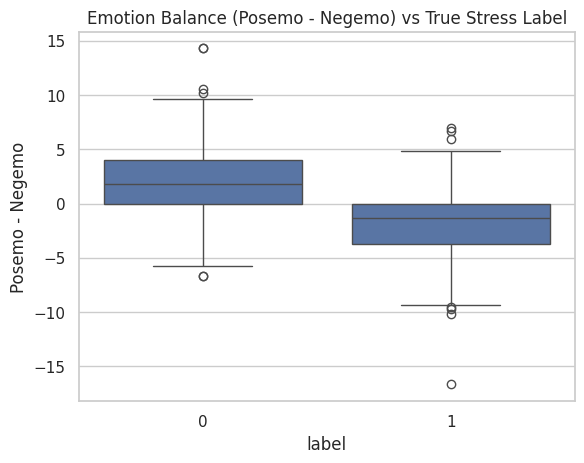

In [ ]:
test_df["negemo_sum"] = test_df["lex_liwc_anx"] + test_df["lex_liwc_anger"] + test_df["lex_liwc_sad"]
test_df["emotion_balance"] = test_df["lex_liwc_posemo"] - test_df["negemo_sum"]

sns.boxplot(x="label", y="emotion_balance", data=test_df)
plt.title("Emotion Balance (Posemo - Negemo) vs True Stress Label")
plt.ylabel("Posemo - Negemo")
plt.show()

### **6.3 Interpretation**

This pattern confirms that stressed posts tend to contain more negative emotion relative to positive emotion. In other words, emotional valence is structurally aligned with the stress label in the dataset.

However, this analysis also clarifies limitations observed in **Analysis 2**:
- Some false positives contained high negative emotion (e.g., *failed, angry, evicted*) but were not labeled as stressed
- Some false negatives contained relatively balanced or subdued emotional tone, despite representing genuine distress

This suggests that while emotional balance is a strong aggregate signal, stress detection cannot rely solely on emotional polarity. Context, narrative framing, and discourse structure also play important roles.

## **7. Conclusion**
### **7.1 Translating Informal Expression into Clinical Signal**

This project aimed to detect stress signals in informal Reddit posts using a BERT-based classifier, achieving an overall F1-score of 0.8177. However, deeper analyses reveal that stress detection is highly context-dependent and linguistically nuanced.

Three key insights emerged:

**1. Stress Predictability Depends on Community Context**

Subreddit-level analysis showed that performance varies substantially (F1 from 0.719 to 0.900).
- Communities such as `domesticviolence` and `stress` yielded the highest performance, likely because distress is explicitly articulated.
- In contrast, `relationships` showed the lowest F1, where emotional signals are mixed and embedded within interpersonal narratives.

This suggests that stress is easier to detect when communities normalize direct emotional disclosure. In relational or narrative-heavy contexts, stress becomes more implicit and harder to classify.

**2. The Model Relies Heavily on Surface Emotional Cues**

SHAP analysis of confident errors revealed systematic patterns:

- **False negatives** often involved:

    - Positive relational framing preceding distress
    - Procedural or factual recounting of trauma
    - Subtle or reflective emotional expression

- **False positives** frequently contained:
    - Strong emotional words (*angry, failed, evicted*)
    - Absolute or dramatic language (*never, defy*)
    - High lexical intensity without explicit psychological distress

This indicates that the model performs best when stress is overt and emotionally direct. However, it may misclassify posts where emotional tone does not align neatly with psychological stress.

In short, the model appears sensitive to **emotional intensity**, but less capable of distinguishing:
- Frustration vs. distress
- Narrative reflection vs. acute stress
- External hardship vs. internal psychological strain

**3. Emotion Balance Is a Strong but Incomplete Signal**

The LIWC-based emotion balance analysis showed clear separation between stressed and non-stressed posts. Stressed posts consistently exhibited negative emotional dominance.

This supports the idea that emotional polarity is a powerful aggregate indicator. However:
- Some high-negative-emotion posts were not labeled stressed (false positives)
- Some stressed posts had mixed or controlled emotional tone (false negatives)

Therefore, emotion counts alone are insufficient. Stress is not purely a function of negative affect; it is shaped by context, framing, and narrative structure.

### **7.2 Implications for Real-World Use**

A model like this could support mental health platforms in several ways:

**Monitoring and Prioritisation**

On digital support platforms (e.g., Singapore-based initiatives such as *Let’s Talk* or similar community forums), such a classifier could:
- Automatically flag high-probability stress posts
- Prioritise them for moderator review
- Surface potentially distressed users earlier

The emotion balance metric could serve as a complementary heuristic — for example, posts with both high predicted stress and strongly negative emotion balance could be triaged more urgently.

**Early Detection in Community Spaces**

Because much modern mental health discourse occurs in informal, non-clinical environments, automated systems could help identify distress signals that would otherwise go unnoticed in high-volume forums.

However, this system should function as a **decision-support tool**, not an autonomous intervention mechanism.

### **7.3 Limitations and Risks**

Several risks must be considered before deployment:

**1. Over-Reliance on Emotional Intensity**

As seen in false positives, the model may overinterpret anger, frustration, or hardship as stress. Automatically intervening in such cases could:
- Mislabel normal relational conflict as psychological distress
- Reduce user trust if flagged unnecessarily

**2. Missing Subtle or Narratively Embedded Stress**

False negatives show that stress expressed through:
- Controlled tone
- Legal or procedural recounting
- Mixed emotional framing

may go undetected. This raises concerns about missing users who need support but do not express distress overtly.

**3. Linguistic and Cultural Bias**

The model is trained on Reddit-style English text. It may:
- Underperform on multilingual slang or culturally specific phrasing
- Miss stress signals expressed indirectly
- Be biased toward communities that use explicit emotional vocabulary

Deployment in Singapore or other multicultural contexts would require validation across linguistic styles and local discourse norms.

### **7.4 Final Reflection**

This project demonstrates that stress detection from informal text is feasible, but inherently imperfect. While the model captures strong emotional signals effectively, stress is not merely a lexical phenomenon — it is socially constructed, narratively embedded, and context-dependent.

Therefore, real-world use should combine:
- Model predictions
- Linguistic heuristics (e.g., emotion balance)
- Human moderation
- Cultural contextualisation

Rather than replacing human judgment, such systems should augment it — helping translate large volumes of digital expression into actionable insights while acknowledging the limits of algorithmic interpretation.

**GitHub Repository:** https://github.com/tungyifaye/DSA4262